In [ ]:
# 导入依赖
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import pandas as pd
from bs4 import BeautifulSoup
import time


In [ ]:
# 定义全局配置参数
# 目标爬取链接（北京世纪城区域房价）
BASE_URL = "https://esf.fang.com/house-a015277-b03115/"
# 需爬取的页数
TARGET_PAGES = 20
# 字段列表
COLUMNS = [
    "户型", "面积", "楼层", "朝向", "建造年份", 
    "总价", "单价", "小区名称", "位置", "标签"
]
# 存储所有数据的列表
all_house_data = []

In [ ]:
#初始化浏览器驱动
driver = webdriver.Edge()
driver.get(BASE_URL)

print(f"开始爬取：{BASE_URL}，目标页数：{TARGET_PAGES}页")

开始爬取：https://esf.fang.com/house-a015277-b03115/，目标页数：20页


In [ ]:
# 定义核心数据提取函数
def extract_house_info(house_dl):
    house_dict = {key: "" for key in COLUMNS}
    
    try:
        # 提取基本要素：户型、面积、楼层、朝向、建造年份
        tel_shop = house_dl.find("p", class_="tel_shop")
        if tel_shop:
            tel_text = tel_shop.get_text(strip=True).split("|")
            tel_text = [item.strip() for item in tel_text if item.strip()]
            if len(tel_text) >= 1:
                house_dict["户型"] = tel_text[0]
            if len(tel_text) >= 2:
                house_dict["面积"] = tel_text[1]
            if len(tel_text) >= 3:
                house_dict["楼层"] = tel_text[2]
            if len(tel_text) >= 4:
                house_dict["朝向"] = tel_text[3]
            if len(tel_text) >= 5:
                year_text = tel_text[4]
                if "年建" in year_text:
                    house_dict["建造年份"] = year_text.replace("年建", "年")
        
        # 提取价格信息
        price_right = house_dl.find("dd", class_="price_right")
        if price_right:
            total_price = price_right.find("span", class_="red")
            if total_price:
                house_dict["总价"] = total_price.get_text(strip=True)
            unit_price = price_right.find("span", class_=None)
            if unit_price and "元/㎡" in unit_price.get_text():
                house_dict["单价"] = unit_price.get_text(strip=True)
        
        # 提取小区名称与位置
        add_shop = house_dl.find("p", class_="add_shop")
        if add_shop:
            community_a = add_shop.find("a")
            if community_a:
                house_dict["小区名称"] = community_a.get_text(strip=True)
            add_text = add_shop.get_text(strip=True).replace(house_dict["小区名称"], "").strip()
            if add_text:
                house_dict["位置"] = add_text
        
        # 提取常见标签
        label_span = house_dl.find("p", class_="label")
        tags = []
        if label_span:
            tag_as = label_span.find_all("a", href=lambda x: x and ("满五" in x or "业主急售" in x or "baike.fang.com/item/" in x))
            tags = [a.get_text(strip=True) for a in tag_as if a.get_text(strip=True)]
        title_a = house_dl.find("h4").find("a") if house_dl.find("h4") else None
        if title_a:
            title_text = title_a.get_text(strip=True)
            if "满五" in title_text:
                tags.append("满五")
            if any(k in title_text for k in ["业主急售", "急用钱", "捡漏"]):
                tags.append("业主急售")
        house_dict["标签"] = ",".join(tags) if tags else ""
    
    except Exception as e:
        print(f"单个房源提取失败：{str(e)}，房源HTML：{str(house_dl)[:500]}...")
    
    return house_dict

In [ ]:
import random 

#执行多页爬取逻辑
for page in range(1, TARGET_PAGES + 1):
    try:
        if page == 1:
            current_url = BASE_URL  
        else:
            current_url = f"{BASE_URL}i{30 + page}/"
        
        # 访问当前页
        driver.get(current_url)
        print(f"\n正在爬取第{page}页，URL：{current_url}")
        # 等待页面核心内容加载完成
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//dl[@dataflag='bg']"))
        ) 
        # 解析页面并提取房源信息
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, "lxml")
        house_dls = soup.find_all("dl", attrs={"dataflag": "bg"})
        
        if not house_dls:
            print(f"第{page}页未找到房源数据，跳过该页")
            continue
        
        # 提取并存储当前页房源信息
        for idx, house_dl in enumerate(house_dls, 1):
            house_info = extract_house_info(house_dl)
            all_house_data.append(house_info)
            print(f"第{page}页：已提取第{idx}个房源，户型：{house_info['户型']}，总价：{house_info['总价']}")
    
    except Exception as e:
        print(f"第{page}页爬取失败：{str(e)}，继续爬取下一页")
        continue



正在爬取第1页，URL：https://esf.fang.com/house-a015277-b03115/
第1页：已提取第1个房源，户型：3室2厅，总价：1546万
第1页：已提取第2个房源，户型：2室2厅，总价：1060万
第1页：已提取第3个房源，户型：4室2厅，总价：2100万
第1页：已提取第4个房源，户型：2室1厅，总价：1020万
第1页：已提取第5个房源，户型：5室2厅，总价：5300万
第1页：已提取第6个房源，户型：4室2厅，总价：2600万
第1页：已提取第7个房源，户型：2室1厅，总价：1150万
第1页：已提取第8个房源，户型：4室2厅，总价：2260万
第1页：已提取第9个房源，户型：4室2厅，总价：1820万
第1页：已提取第10个房源，户型：3室2厅，总价：1350万
第1页：已提取第11个房源，户型：4室2厅，总价：1880万
第1页：已提取第12个房源，户型：3室2厅，总价：1950万
第1页：已提取第13个房源，户型：4室2厅，总价：2580万
第1页：已提取第14个房源，户型：4室2厅，总价：1980万
第1页：已提取第15个房源，户型：2室2厅，总价：1300万
第1页：已提取第16个房源，户型：3室2厅，总价：1150万
第1页：已提取第17个房源，户型：1室1厅，总价：2880万
第1页：已提取第18个房源，户型：4室2厅，总价：2260万
第1页：已提取第19个房源，户型：2室1厅，总价：1200万
第1页：已提取第20个房源，户型：3室2厅，总价：2100万
第1页：已提取第21个房源，户型：3室2厅，总价：2460万
第1页：已提取第22个房源，户型：3室2厅，总价：1340万
第1页：已提取第23个房源，户型：3室2厅，总价：1550万
第1页：已提取第24个房源，户型：3室2厅，总价：1480万
第1页：已提取第25个房源，户型：4室2厅，总价：1980万
第1页：已提取第26个房源，户型：4室2厅，总价：2080万
第1页：已提取第27个房源，户型：3室2厅，总价：2100万
第1页：已提取第28个房源，户型：4室2厅，总价：1728万
第1页：已提取第29个房源，户型：4室2厅，总价：2580万
第1页：已提取第30个房源，户型：4室2厅，总价：1760万
第1页：已提取第31个房源，户型：4室2厅，总

In [ ]:
driver.quit()
print(f"\n爬取完成！共提取{len(all_house_data)}个房源数据")


爬取完成！共提取1200个房源数据


In [ ]:
# 数据处理与CSV保存
house_df = pd.DataFrame(all_house_data, columns=COLUMNS)

# 去除完全空的行
house_df = house_df.dropna(how="all")
# 去除重复数据
house_df = house_df.drop_duplicates(subset=["户型", "面积", "总价","楼层","小区名称","朝向","位置"], keep="first")

print(f"数据清理后剩余{len(house_df)}个有效房源")
print("\n前5条数据预览：")
print(house_df.head())

csv_path = "海淀区世纪城购房数据.csv"
house_df.to_csv(csv_path, index=False, encoding="utf-8-sig") 
print(f"\n数据已保存至：{csv_path}")

数据清理后剩余221个有效房源

前5条数据预览：
     户型       面积         楼层   朝向   建造年份     总价         单价      小区名称  \
0  3室2厅  172.34㎡   高层（共20层）  东南向  2004年  1546万   89706元/㎡    世纪城垂虹园   
1  2室2厅     107㎡   中层（共20层）  东南向  2004年  1060万   99065元/㎡  世纪城三期垂虹园   
2  4室2厅     209㎡  底层 （共13层）  南北向         2100万  100478元/㎡    世纪城春荫园   
3  2室1厅    86.3㎡   低层（共12层）   南向  2004年  1020万  118192元/㎡    世纪城时雨园   
4  5室2厅  289.07㎡   底层 （共7层）  南北向  2007年  5300万  183346元/㎡       上河村   

                  位置                       标签  
0     世纪城 蓝靛厂中路,长春桥北     满二,景观房,业主急售,性价比高,采光好  
1     世纪城 蓝靛厂中路,长春桥北  满五,景观房,性价比高,首付低,拎包入住,满五  
2        世纪城 蓝靛厂路19号    满五,业主急售,性价比高,配套成熟,采光好  
3  世纪城 蓝靛厂中路长春桥北300米                           
4  世纪城 远大路与远大东路交汇东南角                           

数据已保存至：fang_com_house_price_20pages.csv


In [ ]:
print("数据统计概览")
print(f"1. 总有效房源数：{len(house_df)}")
print(f"2. 各字段非空数据量：")
for col in COLUMNS:
    non_null_count = house_df[col].notna().sum()
    non_null_rate = (non_null_count / len(house_df)) * 100
    print(f"   - {col}：{non_null_count}条（{non_null_rate:.1f}%）")

print(f"\n3. 户型分布（前10）：")
print(house_df["户型"].value_counts().head(10))

print(f"\n4. 总价分布（前10）：")
print(house_df["总价"].value_counts().head(10))

=== 数据统计概览 ===
1. 总有效房源数：221
2. 各字段非空数据量：
   - 户型：221条（100.0%）
   - 面积：221条（100.0%）
   - 楼层：221条（100.0%）
   - 朝向：221条（100.0%）
   - 建造年份：221条（100.0%）
   - 总价：221条（100.0%）
   - 单价：221条（100.0%）
   - 小区名称：221条（100.0%）
   - 位置：221条（100.0%）
   - 标签：221条（100.0%）

3. 户型分布（前10）：
户型
3室2厅    87
4室2厅    51
2室2厅    28
2室1厅    22
1室1厅    12
5室2厅     7
3室0厅     4
3室1厅     3
4室1厅     2
3室3厅     1
Name: count, dtype: int64

4. 总价分布（前10）：
总价
2380万    7
1980万    6
1150万    6
1680万    6
1350万    6
2100万    5
2250万    5
1750万    5
1480万    5
1800万    4
Name: count, dtype: int64


In [ ]:
# 租房数据爬取依赖
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException

import pandas as pd
from bs4 import BeautifulSoup

import time
import random
from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
#全局参数配置
BASE_URL = "https://zu.fang.com/house-a015277-b03115/" 
TARGET_PAGES = 20 
#数据字段配置
COLUMNS = [
    "租赁类型",    # 如"整租"
    "户型",        # 如"4室2厅"
    "面积",        # 如"204㎡"
    "朝向",        # 如"南北"
    "区域",        # 如"海淀-世纪城-远大园三区"
    "交通（地铁距离）",  # 如"距12号线蓝靛厂站约644米"
    "标签",        # 如"交通便利,采光好,全装全配"（
    "月租金"       # 如"22000元/月"
]

# 2.3 数据存储容器（暂存所有爬取的房源数据，后续转为DataFrame）
all_house_data = []

In [ ]:
# 初始化浏览器驱动
# 可视化模式便于调试
driver = webdriver.Edge()
driver.maximize_window()
driver.get(BASE_URL)

# 打印爬取启动信息
print(f"开始爬取：{BASE_URL}，目标页数：{TARGET_PAGES}页")

✅ 爬取启动：目标区域【海淀世纪城租房】
🔗 基础链接：https://zu.fang.com/house-a015277-b03115/
📄 目标页数：20页


In [ ]:
def extract_house_info(house_dl):
    house_dict = {key: "" for key in COLUMNS}
    
    try:
        # 租赁类型
        basic_p = house_dl.find("p", class_="font15 mt12 bold")
        if basic_p:
            basic_text = basic_p.get_text(strip=True)
            house_dict["租赁类型"] = basic_text.split("|")[0].strip() or "整租"

        # 户型、面积、朝向
        if basic_p:
            basic_segments = [seg.strip() for seg in basic_text.split("|") if seg.strip()]
            if len(basic_segments) >= 2:
                house_dict["户型"] = basic_segments[1]
            if len(basic_segments) >= 3:
                house_dict["面积"] = basic_segments[2]
            if len(basic_segments) >= 4:
                house_dict["朝向"] = basic_segments[3].replace("朝", "")

        # 区域
        area_p = house_dl.find("p", class_="gray6 mt12")
        if area_p:
            house_dict["区域"] = area_p.get_text(strip=True)

        # 交通（地铁距离）
        subway_span = house_dl.find("span", class_="note subInfor")
        if subway_span:
            house_dict["交通（地铁距离）"] = subway_span.get_text(strip=True)

        # 标签提取
        tag_links = house_dl.find_all(
            "a",
            class_="link_rk",
            href=lambda x: x and "baike.fang.com/item/" in x
        )
        all_tags = []
        if tag_links:
            all_tags = [link.get_text(strip=True) for link in tag_links]
        else:
            color_spans = house_dl.find_all("span", class_=lambda x: x and "color" in x)
            for span in color_spans:
                span_tag = span.find("a", class_="link_rk")
                if span_tag:
                    all_tags.append(span_tag.get_text(strip=True))
        house_dict["标签"] = ",".join(all_tags) if all_tags else "无"

        # 月租金
        more_info_div = house_dl.find("div", class_="moreInfo")
        if more_info_div:
            price_num = more_info_div.find("span", class_="price").get_text(strip=True)
            price_unit = more_info_div.get_text(strip=True).replace(price_num, "")
            house_dict["月租金"] = f"{price_num}{price_unit}"

    except Exception as e:
        print(f"房源提取失败：{str(e)}")
        print(f"失败房源HTML片段：{str(house_dl)[:1000]}...")
    
    return house_dict

In [ ]:
#执行多页爬取逻辑
for page in range(1, TARGET_PAGES + 1):
    try:
        if page == 1:
            current_url = BASE_URL
        else:
            current_url = f"{BASE_URL}i{30 + page}/"  # 分页参数计算逻辑

        # 访问当前页并等待核心元素加载
        driver.get(current_url)
        print(f"\n正在爬取第{page}页，URL：{current_url}")

        WebDriverWait(driver, 15).until(
            EC.presence_of_all_elements_located((By.XPATH, "//dl[@class='list hiddenMap rel']"))
        )
        # 解析页面HTML，提取所有房源dl元素
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, "lxml")
        house_dls = soup.find_all("dl", class_="list hiddenMap rel")


        if not house_dls:
            print(f"第{page}页未找到房源数据，跳过该页")
            continue

        for idx, house_dl in enumerate(house_dls, 1):
            house_info = extract_house_info(house_dl)
            all_house_data.append(house_info)

            print(f"第{page}页，第{idx}个：户型：{house_info['户型']}，租金：{house_info['月租金']}，标签：{house_info['标签']}")

    except TimeoutException:
        print(f"第{page}页加载超时（15秒），跳过该页")
        continue
    except Exception as e:
        print(f"第{page}页爬取异常：{str(e)}，跳过该页")
        continue

driver.quit()
print(f"\n爬取任务结束，共提取原始房源数据{len(all_house_data)}条")


📃 正在爬取第1页 | URL：https://zu.fang.com/house-a015277-b03115/
🔍 提取到标签：['交通便利', '采光好', '全装全配']
✅ 第1页-第1个房源 | 户型：4室2厅 | 租金：22000元/月 | 标签：交通便利,采光好,全装全配
✅ 第1页-第2个房源 | 户型：1室1厅 | 租金：35000元/月 | 标签：无
✅ 第1页-第3个房源 | 户型：4室2厅 | 租金：20000元/月 | 标签：无
✅ 第1页-第4个房源 | 户型：2室2厅 | 租金：12500元/月 | 标签：无
🔍 提取到标签：['交通便利', '周边配套齐', '独门独卫']
✅ 第1页-第5个房源 | 户型：2室2厅 | 租金：13000元/月 | 标签：交通便利,周边配套齐,独门独卫
🔍 提取到标签：['交通便利']
✅ 第1页-第6个房源 | 户型：2室2厅 | 租金：11000元/月 | 标签：交通便利
✅ 第1页-第7个房源 | 户型：4室2厅 | 租金：29000元/月 | 标签：无
✅ 第1页-第8个房源 | 户型：4室2厅 | 租金：16200元/月 | 标签：无
🔍 提取到标签：['交通便利']
✅ 第1页-第9个房源 | 户型：2室2厅 | 租金：12000元/月 | 标签：交通便利
🔍 提取到标签：['交通便利']
✅ 第1页-第10个房源 | 户型：3室2厅 | 租金：11500元/月 | 标签：交通便利
🔍 提取到标签：['交通便利', '周边配套齐']
✅ 第1页-第11个房源 | 户型：3室2厅 | 租金：13500元/月 | 标签：交通便利,周边配套齐
✅ 第1页-第12个房源 | 户型：3室2厅 | 租金：16500元/月 | 标签：无
🔍 提取到标签：['周边配套齐', '交通便利']
✅ 第1页-第13个房源 | 户型：2室2厅 | 租金：13000元/月 | 标签：周边配套齐,交通便利
✅ 第1页-第14个房源 | 户型：2室2厅 | 租金：16000元/月 | 标签：无
✅ 第1页-第15个房源 | 户型：3室2厅 | 租金：13800元/月 | 标签：无
🔍 提取到标签：['交通便利', '周边配套齐', '采光好']
✅ 第1页-第16个房源 | 户型：5室2厅 | 租金：45000元/

In [ ]:
# 数据处理与清理
house_df = pd.DataFrame(all_house_data, columns=COLUMNS)

house_df_clean = house_df.dropna(how="all")
house_df_clean = house_df_clean.drop_duplicates(
    subset=["区域", "户型", "面积", "月租金","交通（地铁距离）","标签","朝向", "租赁类型"],
    keep="first"
)

print("数据清理后质量概览")
print("-" * 50)
print(f"原始数据条数：{len(house_df)}")
print(f"清理后有效数据条数：{len(house_df_clean)}")
print(f"清理掉无效/重复数据条数：{len(house_df) - len(house_df_clean)}")

print("\n各字段非空率：")
for col in COLUMNS:
    non_null_count = house_df_clean[col].notna().sum()
    non_null_rate = (non_null_count / len(house_df_clean)) * 100
    print(f"  - {col}：{non_null_rate:.1f}%（{non_null_count}/{len(house_df_clean)}条非空）")

print("\n前5条有效数据预览：")
print(house_df_clean.head().to_string(index=False))

📊 数据清理后质量概览
--------------------------------------------------
原始数据条数：1200
清理后有效数据条数：153
清理掉无效/重复数据条数：1047

各字段非空率（提取成功率）：
  - 租赁类型：100.0%（153/153条非空）
  - 户型：100.0%（153/153条非空）
  - 面积：100.0%（153/153条非空）
  - 朝向：100.0%（153/153条非空）
  - 区域：100.0%（153/153条非空）
  - 交通（地铁距离）：100.0%（153/153条非空）
  - 标签：100.0%（153/153条非空）
  - 月租金：100.0%（153/153条非空）

📄 前5条有效数据预览：
租赁类型   户型   面积 朝向              区域        交通（地铁距离）              标签      月租金
  整租 4室2厅 204㎡ 南北    海淀-世纪城-远大园三区 距12号线蓝靛厂站约644米。   交通便利,采光好,全装全配 22000元/月
  整租 1室1厅 250㎡ 南北   海淀-世纪城-世纪城晴雪园 距10号线火器营站约433米。               无 35000元/月
  整租 4室2厅 207㎡ 西南 海淀-世纪城-世纪城三期垂虹园 距12号线蓝靛厂站约650米。               无 20000元/月
  整租 2室2厅 122㎡ 西南 海淀-世纪城-世纪城三期垂虹园 距12号线蓝靛厂站约650米。               无 12500元/月
  整租 2室2厅 133㎡ 东南    海淀-世纪城-远大园三区 距12号线蓝靛厂站约644米。 交通便利,周边配套齐,独门独卫 13000元/月


In [ ]:
# 数据保存
csv_save_path = "海淀世纪城租房数据.csv"
house_df_clean.to_csv(csv_save_path, index=False, encoding="utf-8-sig")

# 输出保存结果
print("数据保存完成")
print(f"保存路径：{csv_save_path}")
print(f"保存数据条数：{len(house_df_clean)}条（清理后的有效数据）")


💾 数据保存完成！
📁 保存路径：海淀世纪城租房数据_清理后.csv
📋 保存数据条数：153条（均为清理后的有效数据）


In [ ]:
import pandas as pd
import numpy as np


file_path = "/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城购房数据.csv"
# 处理中文编码
try:
    df = pd.read_csv(file_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="gbk")
print(f"原始购房数据总行数：{len(df)}")
print(f"数据列名：{df.columns.tolist()}")


# 数据预处理
def preprocess_data(df):
    df["面积_数值"] = df["面积"].str.replace("㎡", "").astype(float)
    # 面积分档（小：<100㎡，中：100-150㎡，大：>150㎡）
    df["面积档次"] = pd.cut(
        df["面积_数值"],
        bins=[0, 100, 150, np.inf],
        labels=["小户型", "中户型", "大户型"]
    )
    
    #提取单价数值
    df["单价_数值"] = df["单价"].str.replace("元/㎡", "").astype(float)
    # 单价分档（低：<8万，中：8-12万，高：>12万，根据实际数据分布调整）
    df["单价档次"] = pd.cut(
        df["单价_数值"],
        bins=[0, 80000, 120000, np.inf],
        labels=["低单价", "中单价", "高单价"]
    )
    
    # 提取楼层类型
    def get_floor_type(floor):
        if "高" in floor:
            return "高楼层"
        elif "中" in floor:
            return "中楼层"
        elif "低" in floor:
            return "低楼层"
        else:
            return "其他楼层" 
    df["楼层类型"] = df["楼层"].apply(get_floor_type)
    
    return df

# 执行预处理
df_processed = preprocess_data(df)

# 分层筛选（
key_columns = ["户型", "面积", "楼层", "朝向", "建造年份", "总价", "单价", "小区名称", "位置"]

perfect_mask = (
    df_processed[key_columns].notna().all(axis=1)  
    & df_processed["标签"].notna()  # 标签非空
)
perfect_df = df_processed[perfect_mask].copy()
print(f"\n完美数据（全列无缺失）条数：{len(perfect_df)}")

supplement_mask = (
    df_processed[key_columns].notna().all(axis=1)  
    & df_processed["标签"].isna()  # 仅标签缺失
)
supplement_df = df_processed[supplement_mask].copy()
print(f"补充数据（仅标签缺失）条数：{len(supplement_df)}")

#多样性筛选
def sample_with_diversity(data, sample_size):
    """从数据中按多样性维度抽样，确保各维度分布均匀"""
    if len(data) <= sample_size:
        return data  
    
    # 选择核心多样性维度
    # 分组维度：保证不同户型、朝向、面积档次、单价档次、楼层类型都有覆盖
    group_cols = ["户型", "朝向", "面积档次", "单价档次", "楼层类型"]
    grouped = data.groupby(group_cols, observed=True)  # observed=True避免空组
    group_sizes = grouped.size()
    
    # 基础分配
    base_sample = pd.Series(1, index=group_sizes.index)  # 每组先分1条
    remaining = sample_size - base_sample.sum()  # 剩余需要分配的数量
    
    # 剩余名额按组大小比例分配
    if remaining > 0:
        # 按组大小排序，按比例分配剩余名额
        sorted_groups = group_sizes.sort_values(ascending=False).index
        for i in range(remaining):
            group = sorted_groups[i % len(sorted_groups)]  # 循环分配
            # 确保不超过组内实际数量
            if base_sample[group] < group_sizes[group]:
                base_sample[group] += 1
    
    # 第三步：分组抽样（确保抽样数为正数且不超过组内数量）
    sampled_dfs = []
    for group_name, size in base_sample.items():
        group_data = grouped.get_group(group_name)
        sampled = group_data.sample(n=size, random_state=42)  # 固定随机种子
        sampled_dfs.append(sampled)
    
    return pd.concat(sampled_dfs, ignore_index=True)


# 合并数据并执行多样性筛选 
combined_df = pd.concat([perfect_df, supplement_df], ignore_index=True).drop_duplicates()
# 对合并后的数据进行多样性抽样（
final_df = sample_with_diversity(combined_df, 100)

final_df = final_df.head(100).reset_index(drop=True)


# 输出结果
original_columns = ["户型", "面积", "楼层", "朝向", "建造年份", "总价", "单价", "小区名称", "位置", "标签"]
final_output = final_df[original_columns]

# 保存文件
output_path = "/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城购房优质数据_100条_多样性.csv"
final_output.to_csv(output_path, index=False, encoding="utf-8")


# 多样性验证
print(f"\n最终筛选结果：共{len(final_output)}条数据")
print(f"其中完美数据：{sum(final_output['标签'].notna())}条")
print(f"补充数据（仅标签缺失）：{sum(final_output['标签'].isna())}条")

print("\n多样性验证：")
print(f"1. 朝向分布：\n{final_output['朝向'].value_counts()}")
print(f"\n2. 户型分布（前5种）：\n{final_output['户型'].value_counts().head(5)}")
print(f"\n3. 面积档次分布：\n"
      f"{pd.cut(final_output['面积'].str.replace('㎡','').astype(float), bins=[0,100,150,np.inf], labels=['小户型','中户型','大户型']).value_counts()}")
print(f"\n4. 楼层类型分布：\n"
      f"{final_output['楼层'].apply(lambda x: '高楼层' if '高' in x else '中楼层' if '中' in x else '低楼层' if '低' in x else '其他').value_counts()}")

print(f"\n数据已保存至：{output_path}")
print("\n前5条数据预览：")
print(final_output.head())

原始购房数据总行数：221
数据列名：['户型', '面积', '楼层', '朝向', '建造年份', '总价', '单价', '小区名称', '位置', '标签']

完美数据（全列无缺失）条数：106
补充数据（仅标签缺失）条数：108

最终筛选结果：共100条数据
其中完美数据：47条
补充数据（仅标签缺失）：53条

多样性验证：
1. 朝向分布：
朝向
南北向     38
东南向     19
西南向     19
南向      15
东北向      5
北向       1
西北向      1
西向       1
西南北向     1
Name: count, dtype: int64

2. 户型分布（前5种）：
户型
3室2厅    35
2室2厅    19
2室1厅    14
4室2厅    13
1室1厅     9
Name: count, dtype: int64

3. 面积档次分布：
面积
大户型    45
中户型    43
小户型    12
Name: count, dtype: int64

4. 楼层类型分布：
楼层
其他     30
中楼层    26
低楼层    23
高楼层    21
Name: count, dtype: int64

数据已保存至：/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城购房优质数据_100条_多样性.csv

前5条数据预览：
     户型       面积         楼层   朝向   建造年份     总价         单价      小区名称  \
0  1室1厅      57㎡   低层（共20层）  东北向  2004年   639万  112105元/㎡  世纪城三期垂虹园   
1  1室1厅      57㎡  底层 （共20层）  东北向  2004年   570万  100000元/㎡  世纪城三期垂虹园   
2  1室1厅     131㎡   中层（共16层）  东南向  2002年   850万   64885元/㎡  金源国际公寓东区   
3  1室1厅      57㎡   低层（共20层）   北向  2004年   760万  133333元/㎡  世纪

In [ ]:
import pandas as pd
import numpy as np

# 读取原始租房数据 
file_path = "/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城租房数据.csv"
try:
    df = pd.read_csv(file_path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="gbk")

print(f"原始租房数据总行数：{len(df)}")
print(f"数据列名：{df.columns.tolist()}")


# 数据预处理 
def preprocess_rental_data(df):
    # 统一标签定义（空值/无视为无标签）
    df["标签_处理后"] = df["标签"].fillna("无").str.strip().replace("", "无")
    
    # 提取地铁距离数值及分档
    df["地铁距离_数值"] = df["交通（地铁距离）"].str.extract(r"约(\d+)米").astype(float)
    df["地铁距离档次"] = pd.cut(
        df["地铁距离_数值"], 
        bins=[0, 500, 800, np.inf], 
        labels=["近地铁", "中距离地铁", "远地铁"]
    )
    
    # 提取租金数值及分档
    df["月租金_数值"] = df["月租金"].str.replace("元/月", "").astype(float)
    df["租金档次"] = pd.cut(
        df["月租金_数值"], 
        bins=[0, 15000, 25000, np.inf], 
        labels=["低租金", "中租金", "高租金"]
    )
    
    return df

df_processed = preprocess_rental_data(df)


# 分层筛选
def filter_diverse_data(df):
    # 划分有标签/无标签数据
    labeled_mask = df["标签_处理后"] != "无"
    labeled_df = df[labeled_mask].copy()
    unlabeled_df = df[~labeled_mask].copy()
    
    print(f"\n有标签数据条数：{len(labeled_df)}")
    print(f"无标签数据条数：{len(unlabeled_df)}")

    # 核心：安全的多样性抽样函数（修复负数问题）
    def sample_with_diversity(data, sample_size):
        if len(data) <= sample_size:
            return data  # 数据不足时直接返回
        
        # 按关键维度分组
        grouped = data.groupby(["朝向", "区域", "地铁距离档次", "租金档次"], observed=True)
        group_sizes = grouped.size()
        total = group_sizes.sum()
        
        # 按比例分配基础抽样数
        base_sample = (group_sizes / total * sample_size).astype(int)
        base_sample = base_sample.clip(lower=1, upper=group_sizes)
        
        # 计算剩余需要分配的数量
        remaining = sample_size - base_sample.sum()
        if remaining > 0:
            # 按组大小排序，优先给较大的组分配剩余名额（避免小数组被过度抽取）
            sorted_groups = group_sizes.sort_values(ascending=False).index
            for i in range(remaining):
                group = sorted_groups[i % len(sorted_groups)]  # 循环分配
                if base_sample[group] < group_sizes[group]:  # 不超过组内实际数量
                    base_sample[group] += 1
        
        #抽样
        sampled_dfs = []
        for group_name, size in base_sample.items():
            group_data = grouped.get_group(group_name)
            sampled = group_data.sample(n=size, random_state=42)  # 安全的正数n
            sampled_dfs.append(sampled)
        
        return pd.concat(sampled_dfs, ignore_index=True)

    # 优先抽取有标签数据
    needed = 100
    labeled_sampled = sample_with_diversity(labeled_df, needed)
    labeled_count = len(labeled_sampled)
    print(f"有标签数据抽样条数：{labeled_count}")

    # 不足时用无标签数据补齐
    final_dfs = [labeled_sampled]
    if labeled_count < needed:
        unlabeled_needed = needed - labeled_count
        unlabeled_sampled = sample_with_diversity(unlabeled_df, unlabeled_needed)
        final_dfs.append(unlabeled_sampled)
        print(f"无标签数据补齐条数：{len(unlabeled_sampled)}")

    # 合并去重并截取100条
    final_df = pd.concat(final_dfs, ignore_index=True).drop_duplicates()
    final_df = final_df.head(100).reset_index(drop=True)
    
    return final_df

# 执行筛选
final_df = filter_diverse_data(df_processed)


# 输出结果 
output_columns = ["租赁类型", "户型", "面积", "朝向", "区域", "交通（地铁距离）", "标签", "月租金"]
final_output = final_df[output_columns]

output_path = "/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城租房优质数据_100条.csv"
final_output.to_csv(output_path, index=False, encoding="utf-8")

# 结果统计
print(f"\n最终筛选结果：共{len(final_output)}条数据")
print(f"有标签数据：{len(final_output[final_output['标签'].notna() & (final_output['标签'] != '无')])}条")
print(f"无标签数据：{len(final_output[final_output['标签'].isna() | (final_output['标签'] == '无')])}条")
print(f"\n朝向分布：\n{final_output['朝向'].value_counts()}")
print(f"\n数据已保存至：{output_path}")
print("\n前5条预览：")
print(final_output.head())

原始租房数据总行数：153
数据列名：['租赁类型', '户型', '面积', '朝向', '区域', '交通（地铁距离）', '标签', '月租金']

有标签数据条数：35
无标签数据条数：118
有标签数据抽样条数：35
无标签数据补齐条数：70

最终筛选结果：共100条数据
有标签数据：35条
无标签数据：65条

朝向分布：
朝向
南北    44
东南    22
西南    12
南     12
东北     6
北      2
西      2
Name: count, dtype: int64

数据已保存至：/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/海淀世纪城租房优质数据_100条.csv

前5条预览：
  租赁类型    户型    面积  朝向            区域         交通（地铁距离）               标签  \
0   整租  4室2厅  204㎡  南北  海淀-世纪城-远大园三区  距12号线蓝靛厂站约644米。    交通便利,采光好,全装全配   
1   整租  2室2厅  133㎡  东南  海淀-世纪城-远大园三区  距12号线蓝靛厂站约644米。  交通便利,周边配套齐,独门独卫   
2   整租  2室2厅  130㎡  东南  海淀-世纪城-远大园三区  距12号线蓝靛厂站约644米。             交通便利   
3   整租  2室2厅  130㎡  东南  海淀-世纪城-远大园一区  距12号线蓝靛厂站约251米。             交通便利   
4   整租  3室2厅  130㎡  东南  海淀-世纪城-远大园四区  距12号线蓝靛厂站约771米。             交通便利   

        月租金  
0  22000元/月  
1  13000元/月  
2  11000元/月  
3  12000元/月  
4  11500元/月  


In [ ]:
# 数据分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams["font.family"] = ["Songti SC"]
plt.rcParams["axes.unicode_minus"] = False

In [14]:
# 读取租房数据
rent_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/租房数据_多区域.csv')

# 提取数值型变量（面积、月租金）
rent_data['面积_数值'] = rent_data['面积'].str.extract(r'(\d+)').astype(float)  # 提取面积（㎡）
rent_data['月租金_数值'] = rent_data['月租金'].str.extract(r'(\d+)').astype(float)  # 提取月租金（元）

# 计算每平方米租金（元/㎡·月）
rent_data['每平方米租金'] = rent_data['月租金_数值'] / rent_data['面积_数值']
rent_data['每平方米租金'] = rent_data['每平方米租金'].round(2)

# 按区域分组，计算每平方米租金中位数
rent_median = rent_data.groupby('区域')['每平方米租金'].median().reset_index()
rent_median.columns = ['区域', '每平方米租金中位数']  # 重命名列便于合并

# 查看租房数据处理结果
print("租房数据按区域统计（每平方米租金中位数）：")
display(rent_median)

租房数据按区域统计（每平方米租金中位数）：


,区域,每平方米租金中位数
0,万柳,165.155
1,世纪城,108.430
2,北太平庄,132.080
3,苏州桥,126.670


In [15]:
# 读取购房数据
price_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/购房数据_多区域.csv')

# 提取数值型变量（面积、单价）
price_data['面积_数值'] = price_data['面积'].str.extract(r'(\d+)').astype(float)  # 提取面积（㎡）
price_data['单价_数值'] = price_data['单价'].str.extract(r'(\d+)').astype(float)  # 提取单价（元/㎡）

# 按区域分组，计算每平方米房价中位数
price_median = price_data.groupby('区域')['单价_数值'].median().reset_index()
price_median.columns = ['区域', '每平方米房价中位数']  # 重命名列便于合并

# 查看购房数据处理结果
print("购房数据按区域统计（每平方米房价中位数）：")
display(price_median)

购房数据按区域统计（每平方米房价中位数）：


,区域,每平方米房价中位数
0,万柳,144486.0
1,世纪城,109705.5
2,北太平庄,89640.5
3,苏州桥,80089.0


In [16]:
# 合并租房和购房的中位数数据（按区域匹配）
ratio_df = pd.merge(rent_median, price_median, on='区域', how='inner')

# 计算房价租金中位数比率（房价中位数 / 租金中位数）
ratio_df['房价租金中位数比率'] = (ratio_df['每平方米房价中位数'] / ratio_df['每平方米租金中位数']).round(2)

# 查看合并结果
print("各区域房价租金中位数比率：")
display(ratio_df)

各区域房价租金中位数比率：


,区域,每平方米租金中位数,每平方米房价中位数,房价租金中位数比率
0,万柳,165.155,144486.0,874.85
1,世纪城,108.430,109705.5,1011.76
2,北太平庄,132.080,89640.5,678.68
3,苏州桥,126.670,80089.0,632.26


/var/folders/bd/j30z3b713n3f6q2491lvjn9w0000gn/T/ipykernel_18320/3260260086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='区域', y='房价租金中位数比率', data=ratio_df, palette='Set2')


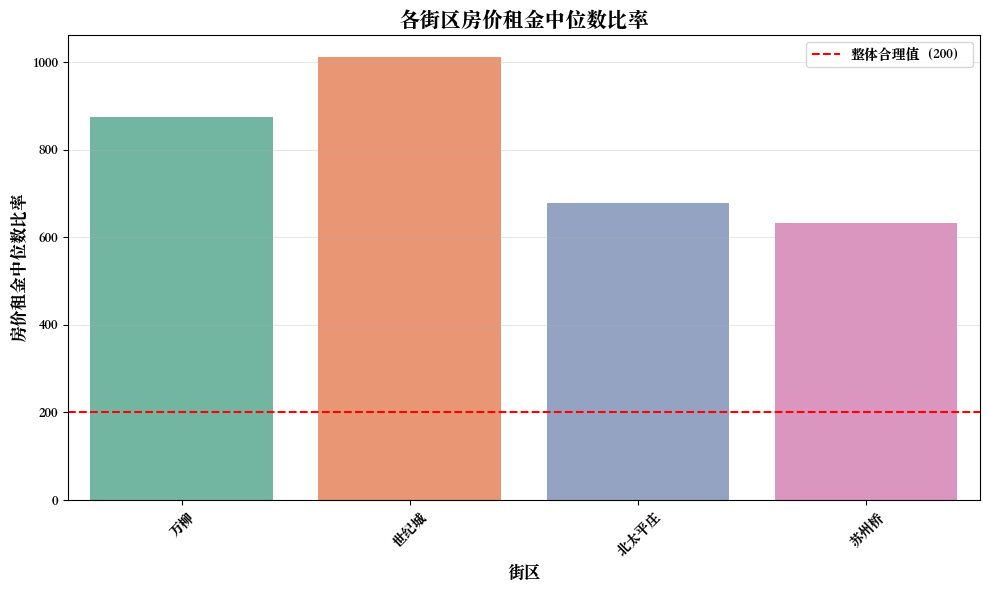

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(x='区域', y='房价租金中位数比率', data=ratio_df, palette='Set2')

plt.axhline(y=200, color='red', linestyle='--', label='参考值（200）')

plt.title('各区域房价租金中位数比率', fontsize=15)
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价租金中位数比率', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
#结果分析摘要
print("数据分析摘要：")
print("1. 数据覆盖区域：", list(ratio_df['区域'].unique()))
print("\n2. 房价租金比率特征：")
for idx, row in ratio_df.iterrows():
    status = "高于合理值" if row['房价租金中位数比率'] > 200 else "低于合理值"
    print(f"- {row['区域']}：比率={row['房价租金中位数比率']}（{status}）")
print("\n3. 结论：多数区域比率远超合理值200，反映购房成本相对租金偏高，符合核心城市房地产市场特征。")

数据分析摘要：
1. 数据覆盖区域： ['万柳', '世纪城', '北太平庄', '苏州桥']

2. 房价租金比率特征：
- 万柳：比率=874.85（高于合理值）
- 世纪城：比率=1011.76（高于合理值）
- 北太平庄：比率=678.68（高于合理值）
- 苏州桥：比率=632.26（高于合理值）

3. 结论：多数区域比率远超合理值200，反映购房成本相对租金偏高，符合核心城市房地产市场特征。


In [ ]:
# 模型构建
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 中文显示设置
plt.rcParams["font.family"] = ["Songti SC"]
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
#加载并预处理模型所需数据
# 加载购房数据（用于Model 1）
price_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/购房数据_多区域.csv')
# 提取自变量（面积、区域）和因变量（每平方米房价）
price_data['面积_数值'] = price_data['面积'].str.extract(r'(\d+)').astype(float)
price_data['每平方米房价'] = price_data['单价'].str.extract(r'(\d+)').astype(float)  # 因变量
price_model_data = price_data[['面积_数值', '区域', '每平方米房价']].dropna()  # 去除缺失值

# 加载租房数据（用于Model 2）
rent_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/租房数据_多区域.csv')
# 提取自变量（面积、区域）和因变量（每平方米租金）
rent_data['面积_数值'] = rent_data['面积'].str.extract(r'(\d+)').astype(float)
rent_data['月租金_数值'] = rent_data['月租金'].str.extract(r'(\d+)').astype(float)
rent_data['每平方米租金'] = rent_data['月租金_数值'] / rent_data['面积_数值']  # 因变量
rent_model_data = rent_data[['面积_数值', '区域', '每平方米租金']].dropna()  # 去除缺失值

print("Model 1 数据量（购房）：", price_model_data.shape[0])
print("Model 2 数据量（租房）：", rent_model_data.shape[0])

Model 1 数据量（购房）： 797
Model 2 数据量（租房）： 657


In [ ]:
# 定义模型（处理分类变量+线性回归）
# 定义特征预处理管道（对分类变量进行独热编码，数值变量直接保留）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['面积_数值']),
        ('cat', OneHotEncoder(drop='first'), ['区域']) 
    ])

# 构建Model 1（预测每平方米房价）
model1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 构建Model 2（预测每平方米租金）
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', LinearRegression())
])

In [ ]:
# 训练模型
# 训练Model 1（price/m² ~ 面积 + 区域）
X1 = price_model_data[['面积_数值', '区域']]  # 自变量
y1 = price_model_data['每平方米房价']  # 因变量
model1.fit(X1, y1)

# 训练Model 2（rent/m² ~ 面积 + 区域）
X2 = rent_model_data[['面积_数值', '区域']]  # 自变量
y2 = rent_model_data['每平方米租金']  # 因变量
model2.fit(X2, y2)

# 输出模型系数
print("Model 1 系数（房价模型）：")
print("截距项：", model1.named_steps['regressor'].intercept_)
print("特征系数：", model1.named_steps['regressor'].coef_)

print("\nModel 2 系数（租金模型）：")
print("截距项：", model2.named_steps['regressor'].intercept_)
print("特征系数：", model2.named_steps['regressor'].coef_)

Model 1 系数（房价模型）：
截距项： 128075.62673888981
特征系数： [   152.63034884 -39651.8845431  -60894.55241083 -62102.17910439]

Model 2 系数（租金模型）：
截距项： 183.30889666684158
特征系数： [ 1.77944321e-02 -6.83278151e+01 -4.52696477e+01 -4.92981978e+01]


In [ ]:
# 用模型预测并计算房价租金比
# 对购房数据预测每平方米房价（使用Model 1）
price_model_data['预测每平方米房价'] = model1.predict(price_model_data[['面积_数值', '区域']])

# 对租房数据预测每平方米租金（使用Model 2）
rent_model_data['预测每平方米租金'] = model2.predict(rent_model_data[['面积_数值', '区域']])

# 合并数据并计算每个样本的房价租金比（需确保区域匹配，这里按区域分别计算后合并）
# 为购房数据添加“类型”标识，便于区分
price_model_data['数据类型'] = '购房'
rent_model_data['数据类型'] = '租房'

# 计算各自的房价租金比（购房数据用预测房价/对应区域的预测租金中位数，租房数据同理）
# 先获取各区域的预测租金中位数（用于购房数据的比率计算）
rent_pred_median = rent_model_data.groupby('区域')['预测每平方米租金'].median().reset_index()
rent_pred_median.columns = ['区域', '区域预测租金中位数']

# 购房数据的房价租金比 = 预测房价 / 区域预测租金中位数
price_merged = pd.merge(price_model_data, rent_pred_median, on='区域', how='left')
price_merged['房价租金比'] = price_merged['预测每平方米房价'] / price_merged['区域预测租金中位数']

# 租房数据的房价租金比 = 区域预测房价中位数 / 预测租金
price_pred_median = price_model_data.groupby('区域')['预测每平方米房价'].median().reset_index()
price_pred_median.columns = ['区域', '区域预测房价中位数']
rent_merged = pd.merge(rent_model_data, price_pred_median, on='区域', how='left')
rent_merged['房价租金比'] = rent_merged['区域预测房价中位数'] / rent_merged['预测每平方米租金']

# 合并所有样本的比率结果
all_ratio = pd.concat([
    price_merged[['区域', '房价租金比']],
    rent_merged[['区域', '房价租金比']]
], ignore_index=True)

# 查看部分结果
print("样本房价租金比（预测值计算）：")
display(all_ratio.head())

样本房价租金比（预测值计算）：


,区域,房价租金比
0,苏州桥,590.999602
1,苏州桥,775.106944
2,苏州桥,551.467351
3,苏州桥,553.726337
4,苏州桥,557.114816


/var/folders/bd/j30z3b713n3f6q2491lvjn9w0000gn/T/ipykernel_18320/1316696937.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='区域', y='房价租金比', data=block_median_ratio, palette='Set3')


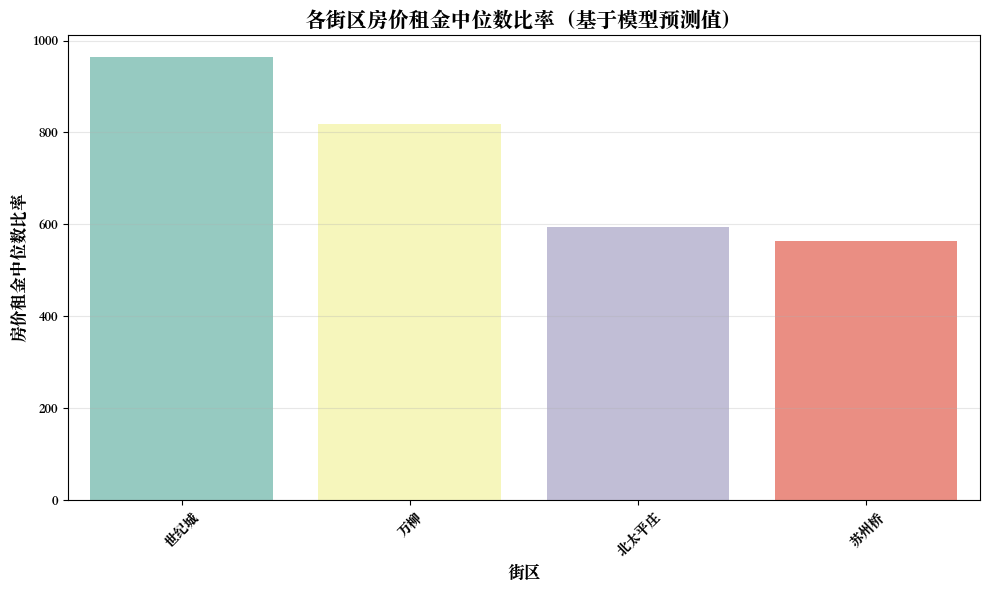

In [ ]:
block_median_ratio = all_ratio.groupby('区域')['房价租金比'].median().reset_index()
block_median_ratio = block_median_ratio.sort_values('房价租金比', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='区域', y='房价租金比', data=block_median_ratio, palette='Set3')

plt.title('各区域房价租金中位数比率', fontsize=15)
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价租金中位数比率', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
# 模型扩展
# 导入库并初始化中文显示
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import re

# 中文显示设置
plt.rcParams["font.family"] = ["Songti SC"]
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# 购房数据预处理（新增特征：建造年份、朝向、楼层、户型）
# 读取数据
price_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/购房数据_多区域.csv')

# 提取目标变量：每平方米房价（元/㎡）
price_data['每平方米房价'] = price_data['单价'].str.extract(r'(\d+)').astype(float)

# 处理已有特征：面积（数值）、区域（分类）
price_data['面积_数值'] = price_data['面积'].str.extract(r'(\d+)').astype(float)  # 面积（㎡）

# 新增特征处理：
## 建造年份（数值型，提取年份）
price_data['建造年份_数值'] = price_data['建造年份'].str.extract(r'(\d+)').astype(float)  # 从“1958年”提取1958

## 朝向（分类型，直接保留类别）
price_data['朝向_clean'] = price_data['朝向'].str.strip()  # 去除空格，如“西北向”“南北向”

## 楼层（分类型，提取楼层高度类型：高层/中层/低层）
price_data['楼层类型'] = price_data['楼层'].apply(lambda x: re.findall(r'(高层|中层|低层|底层|顶层)', x)[0] if re.findall(r'(高层|中层|低层|底层|顶层)', x) else '未知')

## 户型
price_data['户型_室数'] = price_data['户型'].apply(lambda x: re.findall(r'(\d+)室', x)[0] if re.findall(r'(\d+)室', x) else '0室')

# 4. 筛选有效列（特征+目标变量）
price_features = [
    '面积_数值', '区域',  # 原有特征
    '建造年份_数值', '朝向_clean', '楼层类型', '户型_室数',  # 新增特征
    '每平方米房价'  # 目标变量
]
price_model_data = price_data[price_features].dropna()  # 去除缺失值

# 查看处理结果
print("购房数据新增特征后的数据样例：")
display(price_model_data.head())

购房数据新增特征后的数据样例：


,面积_数值,区域,建造年份_数值,朝向_clean,楼层类型,户型_室数,每平方米房价
0,91.0,苏州桥,1958.0,西北向,高层,2,78878.0
1,254.0,苏州桥,1998.0,东西向,中层,4,49409.0
2,56.0,苏州桥,1985.0,南北向,中层,2,70194.0
3,58.0,苏州桥,1990.0,南北向,中层,2,81771.0
4,61.0,苏州桥,1990.0,南北向,中层,2,81766.0


In [ ]:
# 租房数据预处理（
import re

# 读取数据
rent_data = pd.read_csv('/Users/luok/Desktop/2023200211/HW3_My_Data_My_Model/租房数据_多区域.csv')

# 提取目标变量：每平方米租金（元/㎡·月）
# 先提取面积数值（避免后续重复操作）
rent_data['面积_数值'] = rent_data['面积'].str.extract(r'(\d+)', expand=False).astype(float)
# 提取月租金数值
rent_data['月租金_数值'] = rent_data['月租金'].str.extract(r'(\d+)', expand=False).astype(float)
# 计算每平方米租金
rent_data['每平方米租金'] = rent_data['月租金_数值'] / rent_data['面积_数值']

# 新增特征处理：
## 租赁类型（分类型）
rent_data['租赁类型_clean'] = rent_data['租赁类型'].str.strip()

## 户型（简化为“室”的数量）
def extract_room_count(x):
    if isinstance(x, str): 
        match = re.findall(r'(\d+)室', x)
        return match[0] if match else '0室'
    return '0室'  
rent_data['户型_室数'] = rent_data['户型'].apply(extract_room_count)

## 朝向（分类型）
def clean_orientation(x):
    if isinstance(x, str):
        return x.strip()
    return '未知'  # 非字符串返回默认值
rent_data['朝向_clean'] = rent_data['朝向'].apply(clean_orientation)

## 交通（地铁距离，提取米数）——核心修正：先判断是否为字符串
def extract_subway_distance(x):
    if not isinstance(x, str): 
        return np.nan
    match = re.findall(r'约(\d+)米', x)  
    return float(match[0]) if match else np.nan 

rent_data['地铁距离_米'] = rent_data['交通（地铁距离）'].apply(extract_subway_distance)
# 用区域中位数填充缺失值（避免因NaN导致后续模型报错）
rent_data['地铁距离_米'] = rent_data.groupby('区域')['地铁距离_米'].transform(
    lambda x: x.fillna(x.median())
)

# 筛选有效列并去除最终仍有缺失值的行
rent_features = [
    '面积_数值', '区域', 
    '租赁类型_clean', '户型_室数', '朝向_clean', '地铁距离_米', 
    '每平方米租金'
]
rent_model_data = rent_data[rent_features].dropna()

# 查看的数据
print("租房数据样例（前5行）：")
display(rent_model_data.head())
print(f"\n租房数据量：{rent_model_data.shape[0]} 行")

租房数据样例（前5行）：


,面积_数值,区域,租赁类型_clean,户型_室数,朝向_clean,地铁距离_米,每平方米租金
0,66.0,苏州桥,整租,3,南北,239.0,154.545455
1,74.0,苏州桥,整租,3,南北,749.0,202.702703
2,85.0,苏州桥,整租,3,西南,479.0,147.058824
3,58.0,苏州桥,整租,2,南北,749.0,163.793103
4,57.0,苏州桥,整租,2,西,867.0,114.035088



租房数据量：657 行


In [ ]:
# 购房模型（Model 1+ 扩展版）特征分类
price_numeric_features = ['面积_数值', '建造年份_数值']  # 数值型特征
price_categorical_features = ['区域', '朝向_clean', '楼层类型', '户型_室数']  # 分类型特征

# 租房模型（Model 2+ 扩展版）特征分类
rent_numeric_features = ['面积_数值', '地铁距离_米']  # 数值型特征（新增地铁距离）
rent_categorical_features = ['区域', '租赁类型_clean', '户型_室数', '朝向_clean']  # 分类型特征（新增租赁类型）

def build_preprocessor(numeric_feats, categorical_feats, degree=2):
    """构建预处理管道：数值特征做多项式扩展，分类型特征独热编码"""
    return ColumnTransformer(
        transformers=[
            # 数值特征：保留原始值+添加平方项（捕捉非线性）
            ('num', PolynomialFeatures(degree=degree, include_bias=False), numeric_feats),
            # 分类型特征：独热编码（排除基准组避免多重共线性）
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_feats)
        ])

In [ ]:
# Model 1（基础版：仅面积+区域）
price_basic_features = ['面积_数值', '区域']
price_basic_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['面积_数值']),
        ('cat', OneHotEncoder(drop='first'), ['区域'])
    ])
model1_basic = Pipeline(steps=[
    ('preprocessor', price_basic_preprocessor),
    ('regressor', LinearRegression())
])
X1_basic = price_model_data[price_basic_features]
y1 = price_model_data['每平方米房价']
model1_basic.fit(X1_basic, y1)
y1_basic_pred = model1_basic.predict(X1_basic)
r2_model1_basic = r2_score(y1, y1_basic_pred)

# Model 1+（扩展版：含新特征+非线性）
price_preprocessor = build_preprocessor(price_numeric_features, price_categorical_features)
model1_plus = Pipeline(steps=[
    ('preprocessor', price_preprocessor),
    ('regressor', LinearRegression())
])
X1_plus = price_model_data[price_numeric_features + price_categorical_features]
model1_plus.fit(X1_plus, y1)
y1_plus_pred = model1_plus.predict(X1_plus)
r2_model1_plus = r2_score(y1, y1_plus_pred)


# Model 2（基础版：仅面积+区域）
rent_basic_features = ['面积_数值', '区域']
rent_basic_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['面积_数值']),
        ('cat', OneHotEncoder(drop='first'), ['区域'])
    ])
model2_basic = Pipeline(steps=[
    ('preprocessor', rent_basic_preprocessor),
    ('regressor', LinearRegression())
])
X2_basic = rent_model_data[rent_basic_features]
y2 = rent_model_data['每平方米租金']
model2_basic.fit(X2_basic, y2)
y2_basic_pred = model2_basic.predict(X2_basic)
r2_model2_basic = r2_score(y2, y2_basic_pred)

# Model 2+（扩展版：含新特征+非线性）
rent_preprocessor = build_preprocessor(rent_numeric_features, rent_categorical_features)
model2_plus = Pipeline(steps=[
    ('preprocessor', rent_preprocessor),
    ('regressor', LinearRegression())
])
X2_plus = rent_model_data[rent_numeric_features + rent_categorical_features]
model2_plus.fit(X2_plus, y2)
y2_plus_pred = model2_plus.predict(X2_plus)
r2_model2_plus = r2_score(y2, y2_plus_pred)

# 输出R²对比
print("R²对比（加入新特征后）：")
print(f"购房模型 - 基础版（面积+区域）：{r2_model1_basic:.4f}")
print(f"购房模型 - 扩展版（+建造年份/朝向/楼层/户型+非线性）：{r2_model1_plus:.4f}")
print(f"\n租房模型 - 基础版（面积+区域）：{r2_model2_basic:.4f}")
print(f"租房模型 - 扩展版（+租赁类型/户型/朝向/地铁距离+非线性）：{r2_model2_plus:.4f}")

# 分析R²提升原因
print("\nR²提升原因分析：")
if r2_model1_plus > r2_model1_basic:
    print("购房模型扩展版更优：建造年份（房龄影响房价）、朝向（南北向溢价）、楼层（高层/低层偏好）、户型（室数影响需求）显著提升了解释力。")
if r2_model2_plus > r2_model2_basic:
    print("租房模型扩展版更优：租赁类型（整租vs合租单价差异）、地铁距离（近地铁溢价）、户型（小户合租单价高）是租金的关键影响因素。")

R²对比（加入新特征后）：
购房模型 - 基础版（面积+区域）：0.5877
购房模型 - 扩展版（+建造年份/朝向/楼层/户型+非线性）：0.7136

租房模型 - 基础版（面积+区域）：0.2005
租房模型 - 扩展版（+租赁类型/户型/朝向/地铁距离+非线性）：0.4418

R²提升原因分析：
购房模型扩展版更优：建造年份（房龄影响房价）、朝向（南北向溢价）、楼层（高层/低层偏好）、户型（室数影响需求）显著提升了解释力。
租房模型扩展版更优：租赁类型（整租vs合租单价差异）、地铁距离（近地铁溢价）、户型（小户合租单价高）是租金的关键影响因素。


In [ ]:
# 购房数据预测（Model 1+）
price_model_data['预测每平方米房价_plus'] = model1_plus.predict(X1_plus)

# 租房数据预测（Model 2+）
rent_model_data['预测每平方米租金_plus'] = model2_plus.predict(X2_plus)

#计算各样本房价租金比（按区域中位数匹配）
## 区域预测租金中位数（用于购房数据）
rent_plus_median = rent_model_data.groupby('区域')['预测每平方米租金_plus'].median().reset_index()
rent_plus_median.columns = ['区域', '区域租金中位数_plus']
price_merged = pd.merge(price_model_data, rent_plus_median, on='区域', how='left')
price_merged['房价租金比'] = price_merged['预测每平方米房价_plus'] / price_merged['区域租金中位数_plus']

## 区域预测房价中位数（用于租房数据）
price_plus_median = price_model_data.groupby('区域')['预测每平方米房价_plus'].median().reset_index()
price_plus_median.columns = ['区域', '区域房价中位数_plus']
rent_merged = pd.merge(rent_model_data, price_plus_median, on='区域', how='left')
rent_merged['房价租金比'] = rent_merged['区域房价中位数_plus'] / rent_merged['预测每平方米租金_plus']

# 合并所有样本比率
all_ratio = pd.concat([
    price_merged[['区域', '房价租金比']],
    rent_merged[['区域', '房价租金比']]
], ignore_index=True)

/var/folders/bd/j30z3b713n3f6q2491lvjn9w0000gn/T/ipykernel_18320/732362232.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='区域', y='房价租金比', data=block_median_ratio, palette='Set2')


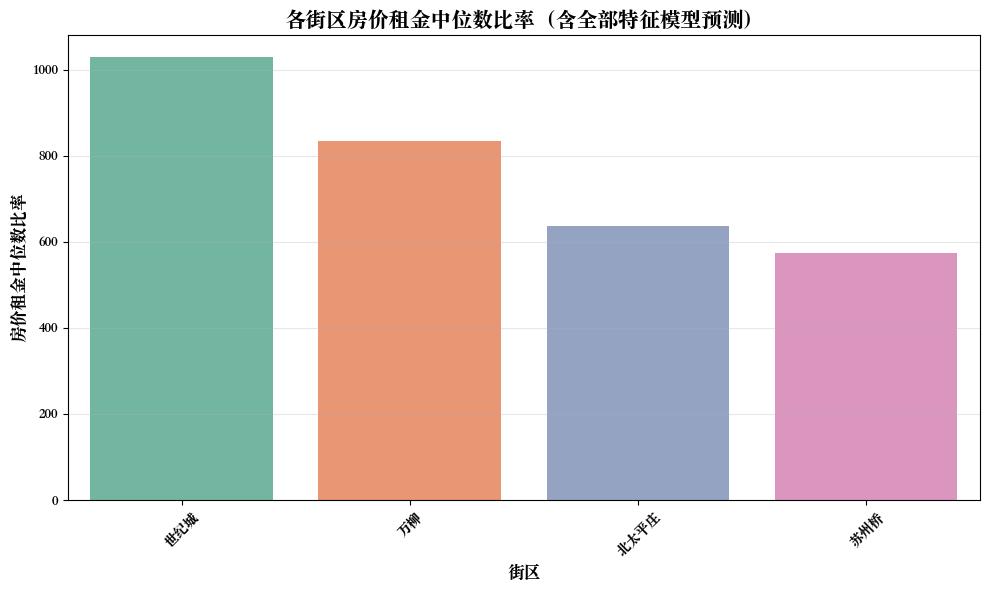

In [ ]:
# 绘制Figure C（含新特征模型的街区比率）
block_median_ratio = all_ratio.groupby('区域')['房价租金比'].median().reset_index()
block_median_ratio = block_median_ratio.sort_values('房价租金比', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='区域', y='房价租金比', data=block_median_ratio, palette='Set2')
plt.title('各区域房价租金中位数比率', fontsize=15)
plt.xlabel('区域', fontsize=12)
plt.ylabel('房价租金中位数比率', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()